# ImageNet Fine Tuning Half
This experiment will involve further fine-tuning the pretrained Xception model. It will explore retraining past the 8 top layers of the base model and for more epochs. The binary labels will be removed to compare multi-class vs binary classification tasks. Class weight-based training, image augmentation, and image loading parallelization will be attempted.

## Setup

In [1]:
!nvidia-smi

Wed Aug 21 20:38:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.28.03              Driver Version: 560.28.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:15:00.0 Off |                    0 |
| N/A   31C    P0             40W /  300W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# !pip install --upgrade pip

In [3]:
# !pip install tensorflow[and-cuda]

In [4]:
!pip install --upgrade keras-cv tensorflow
!pip install --upgrade keras

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [5]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2024-08-21 20:38:52.561005: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-21 20:38:52.575313: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-21 20:38:52.591158: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-21 20:38:52.595734: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-21 20:38:52.607229: I tensorflow/core/platform/cpu_feature_guar

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [7]:
import numpy as np
import keras
# import keras_cv
from keras import layers, regularizers
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
from keras.callbacks import EarlyStopping
import math
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from time import time
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
from concurrent.futures import ThreadPoolExecutor, as_completed
import tensorflow as tf
# from torch.utils.data import DataLoader, Dataset

In [8]:
!pwd
!ls koa_scratch

/home/jctactay
images


## Data preprocessing

In [9]:
# image reading/processing
def load_img(path):
    img = Image.open(path)
    img = img.resize((128,128))
    np_img = np.array(img)/127.5 - 1
    return os.path.basename(path), np_img
def load_images_into_dict(img_dir):
    imgs = {}
    paths = [os.path.join(img_dir, img) for img in os.listdir(img_dir)]

    num_workers = 8
    
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        future_to_img = {executor.submit(load_img, path): path for path in paths}

        for future in as_completed(future_to_img):
            img_name, img = future.result()
            imgs[img_name] = img

    return imgs
    
t0 = time()
home = "/home/jctactay/koa_scratch/images"

imgs = load_images_into_dict(home)
print(f"Done in {time() - t0: .3f}s")

Done in  135.289s


In [10]:
# load/reconcile labels
cols = ["species","image","distinctiveness","quality"]
labels1 = pd.read_csv('pifsc_labels_detail.csv')[cols]
labels1[['quality', 'distinctiveness']] = labels1[['distinctiveness', 'quality']]

cols = ["species","filename","distinctiveness","quality"]
labels2 = pd.read_csv('pifsc_labels2.csv')[cols]
labels2.columns = ["species","image","distinctiveness","quality"]

labels = pd.concat([labels1, labels2]).reset_index(drop=True)

In [11]:
print(len(imgs))

3613


In [12]:
is_na = labels.quality.isna()
labels = labels.loc[~is_na]
labels = labels.drop_duplicates(subset='image', keep='first')

img_names = labels.image.tolist()
features = {k: v for k, v in imgs.items() if k in img_names}
assert len(features) == len(labels)

In [13]:
labels.quality.value_counts()

quality
2    1479
1    1116
3     991
Name: count, dtype: int64

In [14]:
# check for nans
for k, v in zip(features.keys(), features.values()):
    if np.isnan(v.any()):
        print(k)

In [15]:
print(labels)

                 species                           image  distinctiveness  \
0        spinner_dolphin              0011f7a65044e4.jpg              2.0   
1        spinner_dolphin              007097146016e6.jpg              2.0   
2        spinner_dolphin              009a307f9f483c.jpg              2.0   
3        spinner_dolphin              00eea1a5b9d8bc.jpg              2.0   
4        spinner_dolphin              01287e826d29a8.jpg              2.0   
...                  ...                             ...              ...   
3587  melon_headed_whale  PIFSC_20110503-S3_C-5088a-.jpg              2.0   
3588  melon_headed_whale  PIFSC_20110503-S3_Z-3913a-.jpg              1.0   
3589  melon_headed_whale  PIFSC_20110503-S3_Z-3914ed.jpg              NaN   
3590  melon_headed_whale  PIFSC_20110503-S3_C-4846a-.jpg              1.0   
3591  melon_headed_whale  PIFSC_20110503-S3_Z-3866ed.jpg              1.0   

      quality  
0           3  
1           2  
2           1  
3          

In [16]:
Y = labels.quality
# print
if min(np.unique(Y)) != 0:
    for i in range(len(Y)):
        Y.iat[i] -= 1
print(np.unique(Y))
X = np.array([features[i] for i in labels.image])
print(len(Y))
print(len(X))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, stratify=Y_train, random_state=42)

[0 1 2]
3586
3586


In [17]:
print(len(X_train), len(X_val), len(X_test))

2151 717 718


In [18]:
# weights per sample instead of per class
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
print(class_weights)
class_weights_dict = dict(zip(np.unique(Y_train), class_weights))
sample_weights = np.array([class_weights_dict[label] for label in Y_train])
sample_weights

[1.07174888 0.80834273 1.20504202]


array([1.20504202, 1.07174888, 0.80834273, ..., 0.80834273, 1.20504202,
       1.20504202])

In [29]:
augmentation_layers = keras.Sequential([
    keras.layers.RandomFlip(mode="horizontal", seed=42),
    keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, seed=42)
])

poor_augmentation_layers = keras.Sequential([
    keras.layers.RandomRotation(factor=0.1, seed=42),
    # keras_cv.layers.RandomSharpness(factor=0.2, value_range=[0,1], seed=42),
    keras.layers.RandomFlip(mode="vertical", seed=42),
    # keras_cv.layers.RandomSaturation(factor=(0.0, 0.5), seed=42)
])

In [30]:
def augment_image(image, label, weight):
    image = augmentation_layers(image)
    if tf.math.reduce_any(tf.equal(label, 2)):
        image = poor_augmentation_layers(image)
    return image, label, weight

In [31]:
t0 = time()
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train, sample_weights))
train_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
print("Done in %0.3fs" % (time() - t0))

Done in 1.707s


## Visualize augmentations

In [32]:
# Inspect the structure of the dataset
for batch in train_dataset.take(1):
    print("Batch structure:")
    for element in batch:
        print(f"Element shape: {element.shape}")
        print(f"Element type: {type(element)}")

Batch structure:
Element shape: (32, 128, 128, 3)
Element type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Element shape: (32,)
Element type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Element shape: (32,)
Element type: <class 'tensorflow.python.framework.ops.EagerTensor'>


0.29962346
0.30589354
0.2078794
0.37223625
0.5051599
0.5620961
0.4278447
0.3465017
0.2597009
0.13651836
0.67383045
0.2001817
0.59352577
1.0
0.54512364


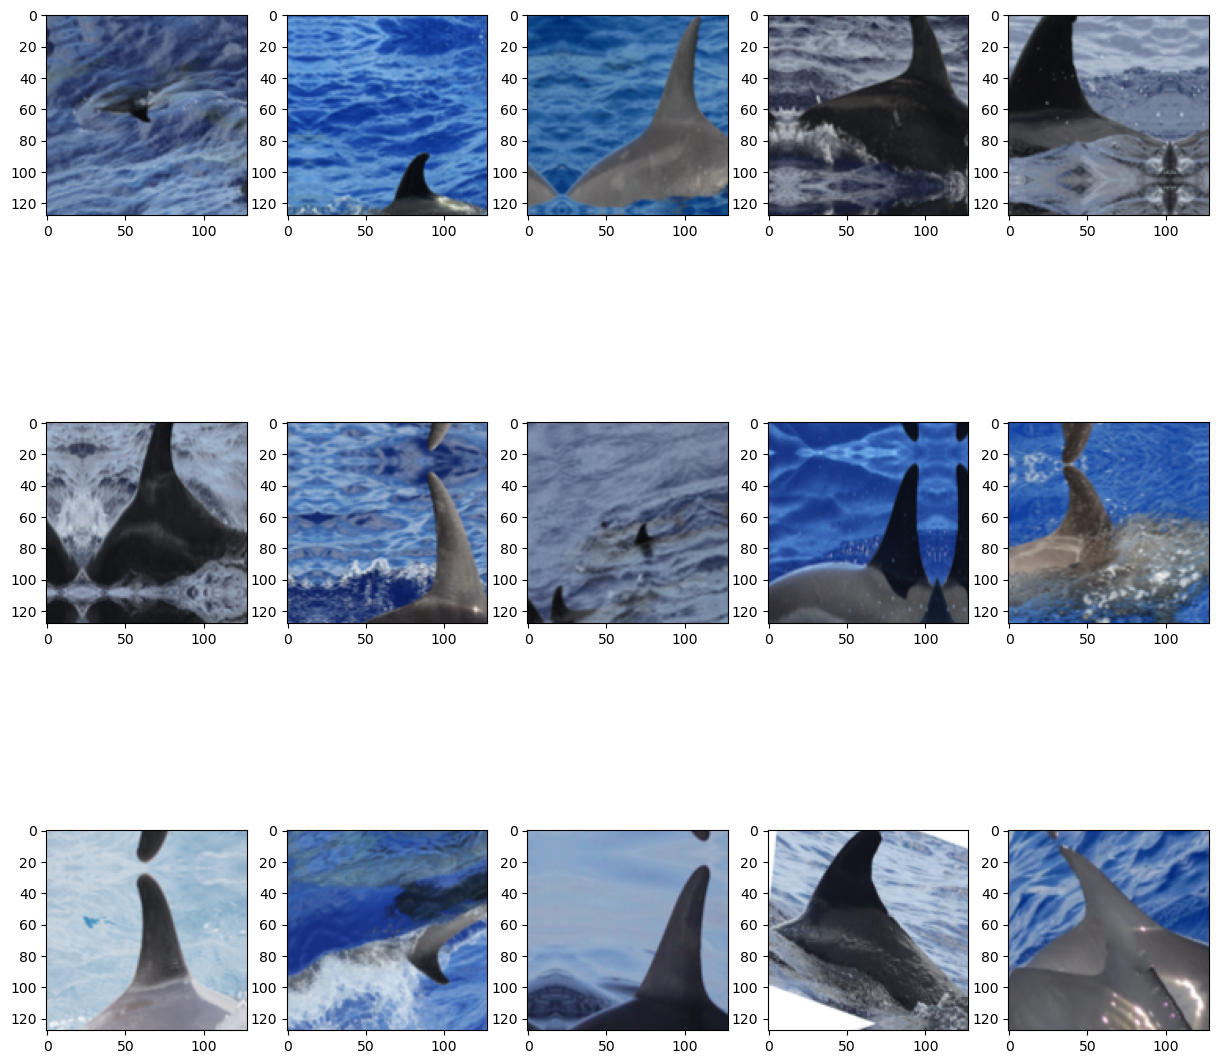

In [33]:
def visualize_augmentation(dataset, num_images=15):
    for batch in dataset.take(1):  # Take one batch
        images, _, _ = batch
        plt.figure(figsize=(15, 15))
        for i in range(min(num_images, images.shape[0])):
            plt.subplot(3, 5, i + 1)
            image = images[i].numpy()
            image = (image + 1) / 2
            plt.imshow(image)
        plt.show()

# Visualize augmented images
visualize_augmentation(train_dataset)

## Model

In [19]:
# load pretrained model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(128,128,3),
    include_top=False)
# freeze base model
base_model.trainable = False

2024-08-21 20:41:14.321397: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0


In [20]:
base_model.summary(show_trainable=True)

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 128,     │         0 │ -              │   -   │
│ (InputLayer)      │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1      │ (None, 63, 63,  │       864 │ input_layer[0… │   N   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_bn   │ (None, 63, 63,  │       128 │ block1_conv1[… │   N   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_act  │ (None, 63, 63,  │         0 │ block1_conv1_… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2      │ (None, 61, 61,  │    18,432 │ block1_conv1_… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_bn   │ (None, 61, 61,  │       256 │ block1_conv2[… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_act  │ (None, 61, 61,  │         0 │ block1_conv2_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1   │ (None, 61, 61,  │     8,768 │ block1_conv2_… │   N   │
│ (SeparableConv2D) │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1_… │ (None, 61, 61,  │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 61, 61,  │         0 │ block2_sepcon… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2   │ (None, 61, 61,  │    17,536 │ block2_sepcon… │   N   │
│ (SeparableConv2D) │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 61, 61,  │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 31, 31,  │     8,192 │ block1_conv2_… │   N   │
│                   │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_pool       │ (None, 31, 31,  │         0 │ block2_sepcon… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 31, 31,  │       512 │ conv2d[0][0]   │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add (Add)         │ (None, 31, 31,  │         0 │ block2_pool[0… │   -   │
│                   │ 128)            │           │ batch_normali… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block3_sepconv1_… │ (None, 31, 31,  │         0 │ add[0][0]      │   - 

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [34]:
# modify input layer
inputs = keras.Input(shape=(128,128,3))
# x = augmentation_layers(inputs)
# inference mode so weights do not update)
x = base_model(inputs, training=False)
# new trainable layers
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = keras.layers.Dropout(0.4)(x)
# x = keras.layers.Dense(512, activation='relu')(x)
# x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(3, activation='softmax')(x)
model = keras.Model(inputs, outputs)
model.summary(show_trainable=True)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_5 (InputLayer)  │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 4, 4, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 1024)          │  2,098,176 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1024)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 3)             │      3,075 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 22,962,731 (87.60 MB)

 Trainable params: 2,101,251 (8.02 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [35]:
callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")

In [36]:
def plot_history(history):
    num_subplots = len(history.history.keys())//2
    fig, ax = plt.subplots(num_subplots)
    for i, metric in enumerate(history.history.keys()):
        ax[i%num_subplots].plot(history.history[metric], label=metric)
        ax[i%num_subplots].legend()

## Initial fit

In [37]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# history = model.fit(X_train, Y_train, epochs=15, validation_data=(X_val, Y_val), sample_weight=sample_weights, callbacks=callback)
history = model.fit(train_dataset, epochs=15, validation_data=val_dataset, callbacks=callback)

Epoch 1/15


I0000 00:00:1724273325.905440 3719740 service.cc:146] XLA service 0x15260b568e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724273325.905470 3719740 service.cc:154]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-08-21 20:48:46.283894: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-21 20:48:47.509163: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


 5/68 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.3828 - loss: 15.0969

I0000 00:00:1724273332.064532 3719740 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


68/68 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - accuracy: 0.4879 - loss: 10.3629 - val_accuracy: 0.4756 - val_loss: 3.6750
Epoch 2/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.6053 - loss: 2.8548 - val_accuracy: 0.4742 - val_loss: 2.1560
Epoch 3/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.5778 - loss: 1.7319 - val_accuracy: 0.4784 - val_loss: 1.7969
Epoch 4/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.5916 - loss: 1.3519 - val_accuracy: 0.4756 - val_loss: 1.5244
Epoch 5/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.5930 - loss: 1.1301 - val_accuracy: 0.4784 - val_loss: 1.3762
Epoch 6/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.6027 - loss: 1.0214 - val_accuracy: 0.4881 - val_loss: 1.3066
Epoch 7/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.5946 - loss: 0.9681 - val_accuracy: 0.4868 - val_loss: 1.2123
Epoch 8/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.6072 - loss: 0.9310 - val_accuracy: 0.4644 - val_loss:

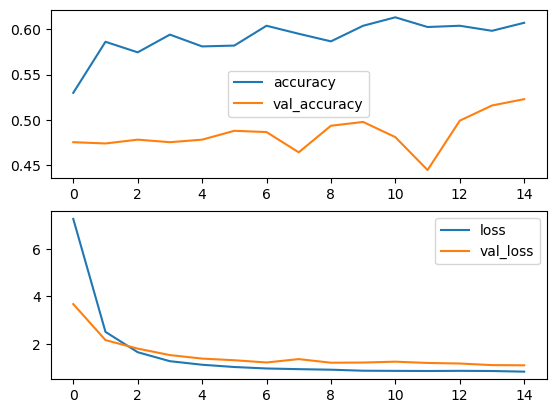

In [38]:
plot_history(history)

In [39]:
results = model.evaluate(X_test, Y_test)
print("test loss, test acc:", results)

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 98ms/step - accuracy: 0.5024 - loss: 1.0581
test loss, test acc: [1.064958930015564, 0.5027855038642883]


In [40]:
pred_soft = model.predict(X_test)
preds = []
for i in pred_soft:
    preds.append(np.argmax(i))
print(classification_report(Y_test, preds))

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step
              precision    recall  f1-score   support

           0       0.52      0.53      0.53       224
           1       0.46      0.49      0.48       296
           2       0.55      0.49      0.52       198

    accuracy                           0.50       718
   macro avg       0.51      0.50      0.51       718
weighted avg       0.50      0.50      0.50       718



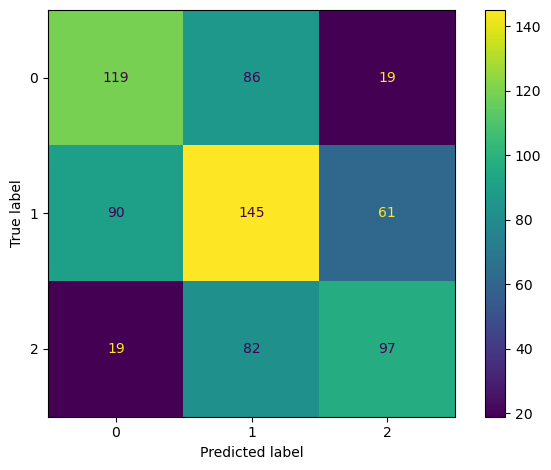

In [41]:
cm = confusion_matrix(Y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.tight_layout()

## Top 4 layers

In [42]:
# unfreeze top 4 base layers
for layer in base_model.layers[-4:]:
    layer.trainable = True
model.summary(show_trainable=True)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_5 (InputLayer)  │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 4, 4, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 1024)          │  2,098,176 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1024)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 3)             │      3,075 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 27,165,235 (103.63 MB)

 Trainable params: 5,264,899 (20.08 MB)

 Non-trainable params: 17,697,832 (67.51 MB)

 Optimizer params: 4,202,504 (16.03 MB)

In [43]:
base_model.summary(show_trainable=True)

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 128,     │         0 │ -              │   -   │
│ (InputLayer)      │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1      │ (None, 63, 63,  │       864 │ input_layer[0… │   N   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_bn   │ (None, 63, 63,  │       128 │ block1_conv1[… │   N   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_act  │ (None, 63, 63,  │         0 │ block1_conv1_… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2      │ (None, 61, 61,  │    18,432 │ block1_conv1_… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_bn   │ (None, 61, 61,  │       256 │ block1_conv2[… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_act  │ (None, 61, 61,  │         0 │ block1_conv2_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1   │ (None, 61, 61,  │     8,768 │ block1_conv2_… │   N   │
│ (SeparableConv2D) │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1_… │ (None, 61, 61,  │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 61, 61,  │         0 │ block2_sepcon… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2   │ (None, 61, 61,  │    17,536 │ block2_sepcon… │   N   │
│ (SeparableConv2D) │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 61, 61,  │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 31, 31,  │     8,192 │ block1_conv2_… │   N   │
│                   │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_pool       │ (None, 31, 31,  │         0 │ block2_sepcon… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 31, 31,  │       512 │ conv2d[0][0]   │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add (Add)         │ (None, 31, 31,  │         0 │ block2_pool[0… │   -   │
│                   │ 128)            │           │ batch_normali… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block3_sepconv1_… │ (None, 31, 31,  │         0 │ add[0][0]      │   - 

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [50]:
callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", start_from_epoch=5)

In [51]:
# top 4 layers unfrozen
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs=20
# history = model.fit(X_train, Y_train, epochs=epochs, batch_size=32, validation_data=(X_val, Y_val), sample_weight=sample_weights, callbacks=callback)
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callback)

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 0.6399 - loss: 0.7687 - val_accuracy: 0.4589 - val_loss: 1.1174
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.6270 - loss: 0.7785 - val_accuracy: 0.4644 - val_loss: 1.1129
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.6349 - loss: 0.7813 - val_accuracy: 0.4784 - val_loss: 1.1083
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.6526 - loss: 0.7551 - val_accuracy: 0.4840 - val_loss: 1.1037
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.6301 - loss: 0.7540 - val_accuracy: 0.4798 - val_loss: 1.1087
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.6638 - loss: 0.7630 - val_accuracy: 0.4798 - val_loss: 1.1072
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.6166 - loss: 0.7722 - val_accuracy: 0.4686 - val_loss: 1.1133
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.6578 - loss: 0.7420 - val_accuracy: 0.4686 

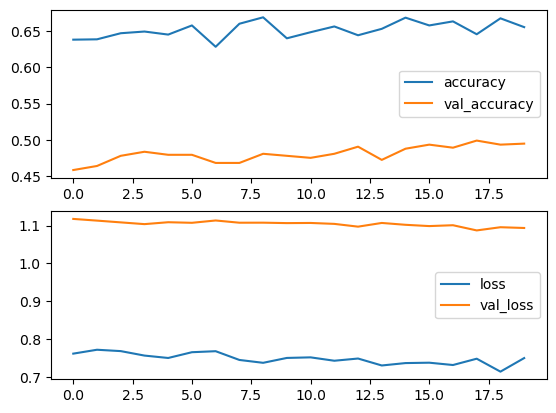

In [52]:
plot_history(history)

In [53]:
results = model.evaluate(X_test, Y_test)
print("test loss, test acc:", results)

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.4951 - loss: 1.0333
test loss, test acc: [1.0362569093704224, 0.5069637894630432]


In [54]:
pred_soft = model.predict(X_test)
preds = []
for i in pred_soft:
    preds.append(np.argmax(i))
print(classification_report(Y_test, preds))

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step
              precision    recall  f1-score   support

           0       0.49      0.74      0.59       224
           1       0.47      0.46      0.46       296
           2       0.72      0.32      0.44       198

    accuracy                           0.51       718
   macro avg       0.56      0.50      0.50       718
weighted avg       0.54      0.51      0.50       718



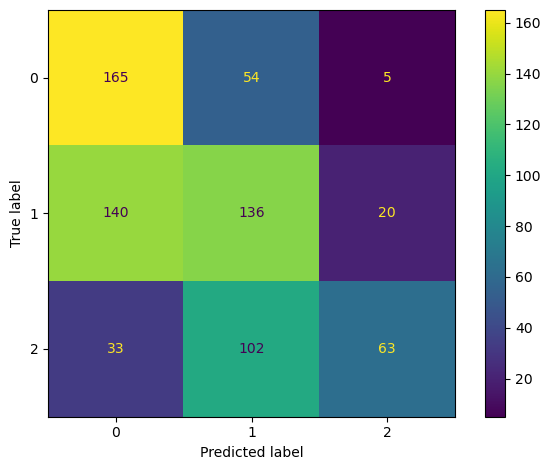

In [55]:
cm = confusion_matrix(Y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.tight_layout()

## Top 8 layers

In [56]:
# unfreeze 4 more base layers
for layer in base_model.layers[-8:]:
    layer.trainable = True
model.summary(show_trainable=True)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_5 (InputLayer)  │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 4, 4, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 1024)          │  2,098,176 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1024)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 3)             │      3,075 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 33,492,531 (127.76 MB)

 Trainable params: 6,852,099 (26.14 MB)

 Non-trainable params: 16,110,632 (61.46 MB)

 Optimizer params: 10,529,800 (40.17 MB)

In [57]:
callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", start_from_epoch=10)

In [58]:
sample_weights

array([1.20504202, 1.07174888, 0.80834273, ..., 0.80834273, 1.20504202,
       1.20504202])

In [59]:
# top 8 layers unfrozen
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs=40
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callback)

Epoch 1/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 19s 161ms/step - accuracy: 0.5500 - loss: 0.9605 - val_accuracy: 0.4616 - val_loss: 1.1361
Epoch 2/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.5914 - loss: 0.8889 - val_accuracy: 0.4686 - val_loss: 1.1917
Epoch 3/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.5957 - loss: 0.8511 - val_accuracy: 0.4742 - val_loss: 1.2149
Epoch 4/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.6331 - loss: 0.8117 - val_accuracy: 0.5105 - val_loss: 1.1628
Epoch 5/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.6468 - loss: 0.7855 - val_accuracy: 0.5160 - val_loss: 1.1292
Epoch 6/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.6596 - loss: 0.7623 - val_accuracy: 0.5188 - val_loss: 1.1242
Epoch 7/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.6424 - loss: 0.7574 - val_accuracy: 0.5272 - val_loss: 1.0992
Epoch 8/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.6634 - loss: 0.7344 - val_accuracy: 0.5314 

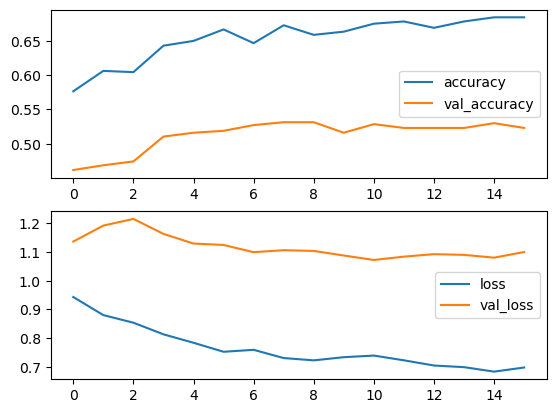

In [60]:
plot_history(history)

In [61]:
results = model.evaluate(X_test, Y_test)
results

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.5277 - loss: 1.0256


[1.0263746976852417, 0.523676872253418]

In [62]:
pred_soft = model.predict(X_test)
preds = []
for i in pred_soft:
    preds.append(np.argmax(i))
print(classification_report(Y_test, preds))

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step
              precision    recall  f1-score   support

           0       0.50      0.71      0.59       224
           1       0.48      0.51      0.49       296
           2       0.76      0.33      0.46       198

    accuracy                           0.52       718
   macro avg       0.58      0.52      0.52       718
weighted avg       0.56      0.52      0.52       718



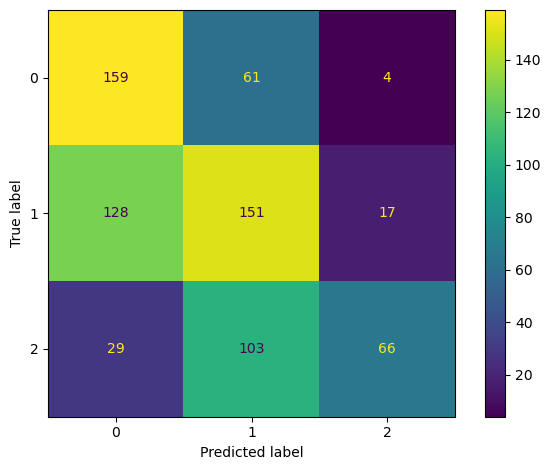

In [63]:
cm = confusion_matrix(Y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.tight_layout()

## Top 12 layers

In [64]:
# unfreeze 2 more base layers
for layer in base_model.layers[-12:]:
    layer.trainable = True
model.summary(show_trainable=True)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_5 (InputLayer)  │ (None, 128, 128, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 4, 4, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 1024)          │  2,098,176 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 1024)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 3)             │      3,075 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 36,666,931 (139.87 MB)

 Trainable params: 8,351,643 (31.86 MB)

 Non-trainable params: 14,611,088 (55.74 MB)

 Optimizer params: 13,704,200 (52.28 MB)

In [65]:
callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", start_from_epoch=15)

In [66]:
# top 12 layers unfrozen
model.compile(optimizer=keras.optimizers.Adam(5e-6),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs=40
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callback)

Epoch 1/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 19s 162ms/step - accuracy: 0.6621 - loss: 0.7466 - val_accuracy: 0.5160 - val_loss: 1.1256
Epoch 2/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.6602 - loss: 0.7604 - val_accuracy: 0.5286 - val_loss: 1.0880
Epoch 3/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.6674 - loss: 0.7474 - val_accuracy: 0.5286 - val_loss: 1.0735
Epoch 4/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.6657 - loss: 0.7251 - val_accuracy: 0.5328 - val_loss: 1.0833
Epoch 5/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.6528 - loss: 0.7520 - val_accuracy: 0.5300 - val_loss: 1.0938
Epoch 6/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.6734 - loss: 0.7027 - val_accuracy: 0.5286 - val_loss: 1.1094
Epoch 7/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.6788 - loss: 0.6844 - val_accuracy: 0.5328 - val_loss: 1.0991
Epoch 8/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.6990 - loss: 0.6967 - val_accuracy: 0.5356 

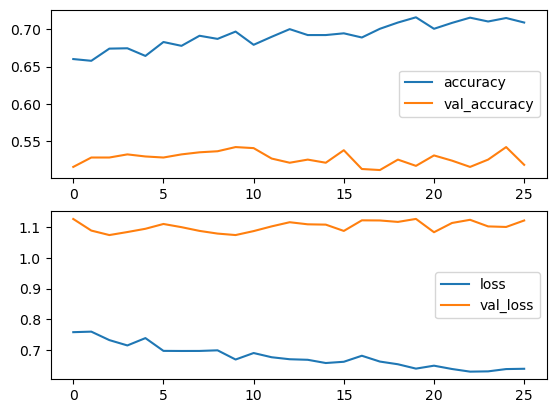

In [67]:
plot_history(history)

In [68]:
pred_soft = model.predict(X_test)
preds = []
for i in pred_soft:
    preds.append(np.argmax(i))
print(classification_report(Y_test, preds))

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step
              precision    recall  f1-score   support

           0       0.52      0.76      0.62       224
           1       0.49      0.52      0.50       296
           2       0.80      0.30      0.44       198

    accuracy                           0.53       718
   macro avg       0.60      0.53      0.52       718
weighted avg       0.58      0.53      0.52       718



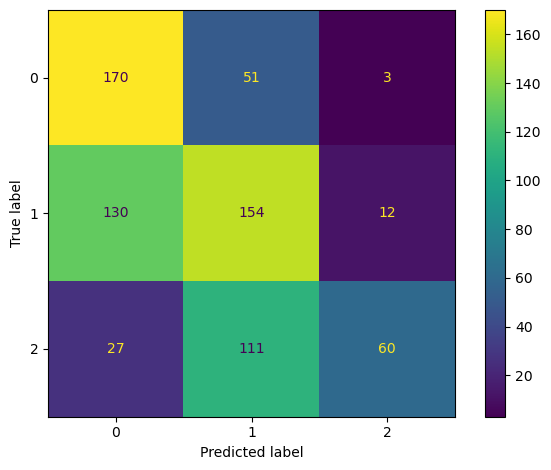

In [69]:
cm = confusion_matrix(Y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.tight_layout()

## Testing half of the top layers

In [70]:
num_base_layers = len(base_model.layers)
num_base_layers

132

In [71]:
# unfreeze half of the layers
for layer in base_model.layers[-(num_base_layers//2):]:
    layer.trainable = True
base_model.summary(show_trainable=True)
# is this a mistake?

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 128,     │         0 │ -              │   -   │
│ (InputLayer)      │ 128, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1      │ (None, 63, 63,  │       864 │ input_layer[0… │   N   │
│ (Conv2D)          │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_bn   │ (None, 63, 63,  │       128 │ block1_conv1[… │   N   │
│ (BatchNormalizat… │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_act  │ (None, 63, 63,  │         0 │ block1_conv1_… │   -   │
│ (Activation)      │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2      │ (None, 61, 61,  │    18,432 │ block1_conv1_… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_bn   │ (None, 61, 61,  │       256 │ block1_conv2[… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_act  │ (None, 61, 61,  │         0 │ block1_conv2_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1   │ (None, 61, 61,  │     8,768 │ block1_conv2_… │   N   │
│ (SeparableConv2D) │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1_… │ (None, 61, 61,  │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 61, 61,  │         0 │ block2_sepcon… │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2   │ (None, 61, 61,  │    17,536 │ block2_sepcon… │   N   │
│ (SeparableConv2D) │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 61, 61,  │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 31, 31,  │     8,192 │ block1_conv2_… │   N   │
│                   │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_pool       │ (None, 31, 31,  │         0 │ block2_sepcon… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 31, 31,  │       512 │ conv2d[0][0]   │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add (Add)         │ (None, 31, 31,  │         0 │ block2_pool[0… │   -   │
│                   │ 128)            │           │ batch_normali… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block3_sepconv1_… │ (None, 31, 31,  │         0 │ add[0][0]      │   - 

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [72]:
callback = EarlyStopping(patience=10, restore_best_weights=True, monitor="val_loss", start_from_epoch=20)

In [73]:
# top half layers unfrozen
model.compile(optimizer=keras.optimizers.Adam(1e-6),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

epochs=60
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callback)

Epoch 1/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.6196 - loss: 0.7859

2024-08-21 21:02:55.883711: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 80 bytes spill stores, 80 bytes spill loads



68/68 ━━━━━━━━━━━━━━━━━━━━ 35s 241ms/step - accuracy: 0.6200 - loss: 0.7857 - val_accuracy: 0.5467 - val_loss: 1.0856
Epoch 2/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.6059 - loss: 0.8144 - val_accuracy: 0.5188 - val_loss: 1.0821
Epoch 3/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.6338 - loss: 0.7680 - val_accuracy: 0.5174 - val_loss: 1.0911
Epoch 4/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - accuracy: 0.6302 - loss: 0.7658 - val_accuracy: 0.5160 - val_loss: 1.1055
Epoch 5/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.6293 - loss: 0.7643 - val_accuracy: 0.5091 - val_loss: 1.1219
Epoch 6/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.6441 - loss: 0.7482 - val_accuracy: 0.5007 - val_loss: 1.1398
Epoch 7/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.6447 - loss: 0.7368 - val_accuracy: 0.5035 - val_loss: 1.1527
Epoch 8/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.6390 - loss: 0.7440 - val_accuracy: 0.5119 - val_loss

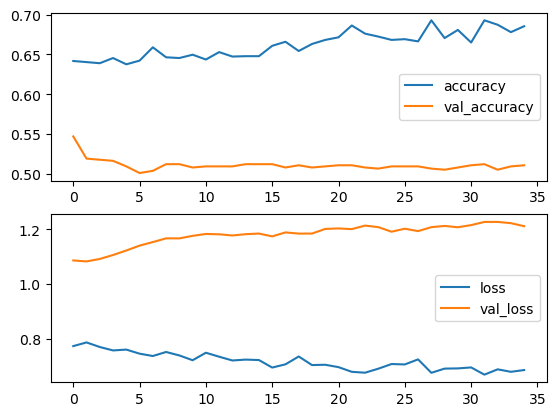

In [74]:
plot_history(history)

In [75]:
pred_soft = model.predict(X_test)
preds = []
for i in pred_soft:
    preds.append(np.argmax(i))
print(classification_report(Y_test, preds))

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step
              precision    recall  f1-score   support

           0       0.49      0.71      0.58       224
           1       0.48      0.46      0.47       296
           2       0.71      0.39      0.51       198

    accuracy                           0.52       718
   macro avg       0.56      0.52      0.52       718
weighted avg       0.55      0.52      0.51       718



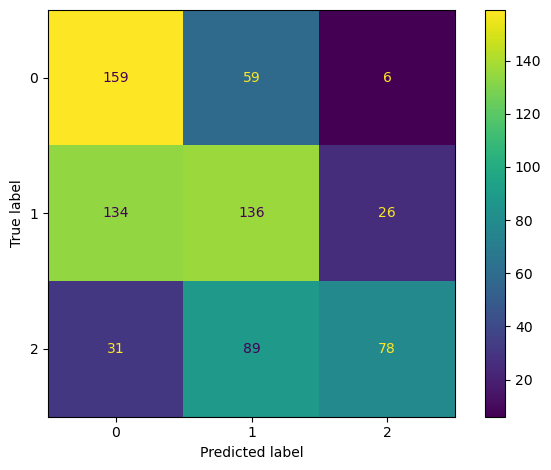

In [76]:
cm = confusion_matrix(Y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.tight_layout()